In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import optimize

### Problem 1

In [3]:
def fun(x,y):
    '''
    y'=y/(1+x^2)
    
    :param x,y: data
    '''
    return y/(1+x**2)

def rk4_step(fun,x,y,h):
    '''
    Returns y-value of one rk4 step using Jon's code from lecture
    
    :param fun: function
    :param x,y: data point
    :param h: step size
    '''
    k1=fun(x,y)*h
    k2=h*fun(x+h/2,y+k1/2)
    k3=h*fun(x+h/2,y+k2/2)
    k4=h*fun(x+h,y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    return y+dy

Let's plot $y(x)$ using rk4_step as well as the resulting error. The solution to the equation is

$$ f(x) = \exp\left[\arctan(20)+\arctan(x)\right].$$

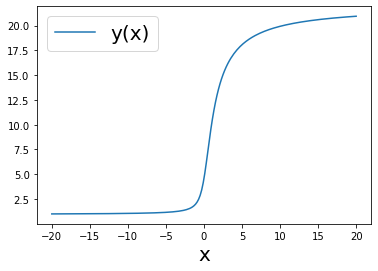

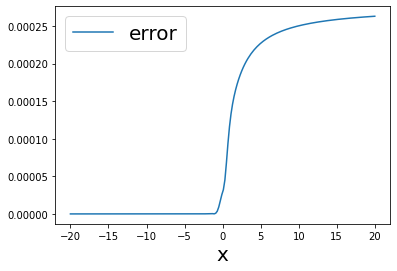

In [4]:
x=np.linspace(-20,20,200)
h=np.median(np.diff(x))
y=np.zeros(len(x))
y[0]=1
for i in range(len(x)-1):
    y[i+1]=rk4_step(fun,x[i],y[i],h)

plt.plot(x,y,label='y(x)')
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.plot(x,np.abs(y-np.exp(np.arctan(20)+np.arctan(x))),label='error')
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=20)
plt.show()

We will now eliminate leading order error by performing two rk4 steps of length $h/2$ and cancelling. This is accomplished by (see Numerical Recipes)

$$ y+dy=y_2+\frac{y_2-y_1}{15},$$

where $y_2$ is the y-value in two steps, and $y_1$ is the y-value in one step. 

In [5]:
def rk4_stepd(fun,x,y,h):
    '''
    Returns y-value of one rk4 with leading order term eliminated using step-doubling
    
    :param fun: function
    :param x,y: data point
    :param h: step size
    '''
    y1=rk4_step(fun,x,y,h) #one step
    ystep1=rk4_step(fun,x,y,h/2)#first step
    y2=rk4_step(fun,x+h/2,ystep1,h/2)#second step
    return y2+(y2-y1)/15 #correction from Numerical Recipes

rk4_stepd uses 12 three function evaluations per step as opposed to 4. Using rk4_stepd, let's plot $y(x)$ and the errors again.

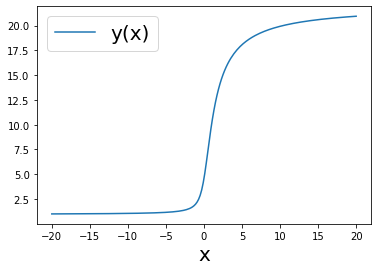

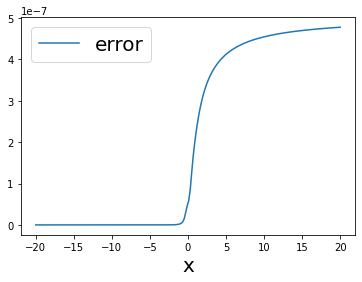

In [6]:
x=np.linspace(-20,20,200)
h=np.median(np.diff(x))
y=np.zeros(len(x))
y[0]=1
for i in range(len(x)-1):
    y[i+1]=rk4_stepd(fun,x[i],y[i],h)

plt.plot(x,y,label='y(x)')
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.plot(x,np.abs(y-np.exp(np.arctan(20)+np.arctan(x))),label='error')
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=20)
plt.show()

Using step-doubling, the errors have improved by a factor of $10^3,$ pretty good. Now let's repeat the calculation using rk4_step with 600 steps, which has the equivalent number of function evaluations to the first integration with rk4_step since it has 1/3 of the function evaluations of rk4_stepd.

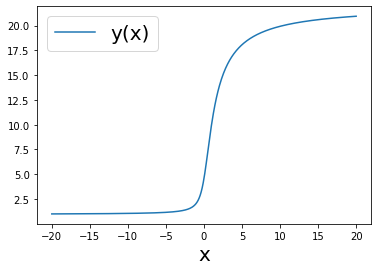

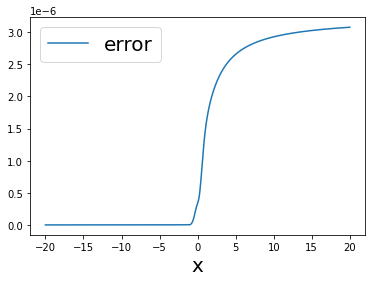

In [7]:
### rk4_step, 600 steps ###

x=np.linspace(-20,20,600)
h=np.median(np.diff(x))
y=np.zeros(len(x))
y[0]=1
for i in range(len(x)-1):
    y[i+1]=rk4_step(fun,x[i],y[i],h)

plt.plot(x,y,label='y(x)')
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.plot(x,np.abs(y-np.exp(np.arctan(20)+np.arctan(x))),label='error')
plt.xlabel('x',fontsize=20)
plt.legend(fontsize=20)
plt.show()

In this case when the number of function evaluations are equivalent we see that rk4_stepd is only 1 order better in error, coming from the cancellation of the leading error term.

### Problem 2

The decay rates are given by

$$ \alpha = \frac{\log{2}}{t_{1/2}},$$

where $t_{1/2}$ is the half-life.

In [6]:
### Part (a) ###
 
hl=np.asarray([4.468*(1e9*365*24*60*60),24.10*(24*60*60),6.70*(60*60),
         245500*(365*24*60*60),75380*(365*24*60*60),1600*(365*24*60*60),
         3.8235*(24*60*60),3.10*(60),26.8*(60),19.9*(60),164.3*(60*1e-6),
         22.3*(365*24*60*60),5.015*(365*24*60*60),138.376*(24*60*60)]) #ordered half-lives in seconds
rate=np.log(2)*hl**(-1) #convert to rates
    
def U238(x,y,r=rate):
    '''
    Computes one timestep of U238 decay
    
    :param x,y: time and abudance data
    :param rate: decay rates of each element
    '''
    dydx=np.zeros(len(r)+1)
    dydx[0]=-y[0]*r[0] #change in U238
    for i in range(1,len(dydx)-1): #change in everything else but Pb206
        dydx[i]=y[i-1]*r[i-1]-y[i]*r[i]
    dydx[-1]=y[-2]*r[-1] #change in Pb206
    return dydx

(b) The analytic ratio is

$$ \frac{Pb206}{U238}=\frac{1-e^{-\alpha t}}{e^{-\alpha t}}=e^{\alpha t}-1,$$

where $\alpha$ is the decay rate of Uranium. Let's plot the numerical ratio and compare it to the analytic formula.

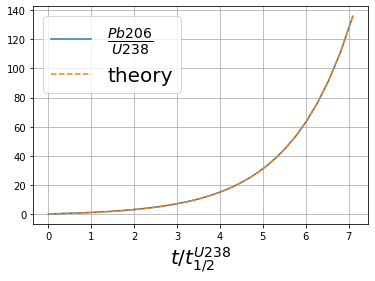

In [7]:
x0,x1=0,10**18 #seconds
y0=np.zeros(len(rate)+1);y0[0]=1 #pure U238
t_eval=np.logspace(0,np.log10(x1),1000)
ans=integrate.solve_ivp(U238,[x0,x1],y0,method='Radau',t_eval=t_eval)

plt.plot(ans.t/hl[0],ans.y[-1]/ans.y[0],label=r'$\frac{Pb206}{U238}$')
plt.plot(ans.t/hl[0],np.exp(rate[0]*ans.t)-1,label='theory',ls='--')
plt.xlabel(r'$t/t^{U238}_{1/2}$',fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

The numerical and analytic ratios agree. We can also plot the ratio of Th230 to U234.

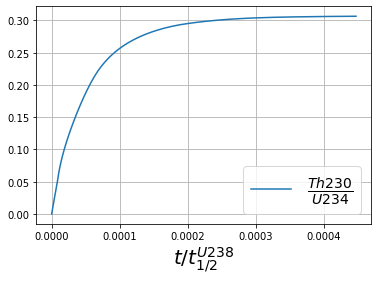

In [8]:
x0,x1=0,10**13.8 #seconds
t_eval=np.logspace(0,np.log10(x1),1000)
ans=integrate.solve_ivp(U238,[x0,x1],y0,method='Radau',t_eval=t_eval)

plt.plot(ans.t[1:]/hl[0],ans.y[4][1:]/ans.y[3][1:],label=r'$\frac{Th230}{U234}$')
plt.xlabel(r'$t/t_{1/2}^{U238}$',fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

The ratio of Th230 to U234 appears to asymptote just above 0.30.

### Problem 3

(a) We may pick

$$ (A,B,C,D)=(z_0+a(x_0^2+y_0^2),-2ax_0,-2ay_0,a) $$

to linearize the problem. The function then becomes

$$ z = A + B x + C y + D (x^2+y^2)$$

In [9]:
### Part(b) ###

x,y,z=np.loadtxt('dish_zenith.txt').T

A=np.zeros((len(x),4)) # data x params matrix
A[:,0]=x**2+y**2
A[:,1]=x
A[:,2]=y
A[:,3]=np.ones(len(x))

m=np.linalg.inv(A.T@A)@A.T@z #linear least squares model parameters

#convert params
a=m[0]
x0=m[1]/(-2*a)
y0=m[2]/(-2*a)
z0=m[3]-a*(x0**2+y0**2)

print('best fit params are [x0,y0,z0,a] =',x0,y0,z0,a)

best fit params are [x0,y0,z0,a] = -1.3604886221980108 58.22147608157856 -1512.8772100367885 0.00016670445477401355


(c) The uncertainty in $a$ is the square root of the first diagonal term in the covariance matrix.

In [10]:
noise=z-A@m #compute noise estimate
N=np.diag(noise) #make the noise matrix
cov=np.linalg.inv(A.T@np.linalg.inv(N)@A) #compute the covariance matrix
print('The uncertainty in a is +/-', np.sqrt(cov[0,0]))

The uncertainty in a is +/- 2.66020872080714e-08


Since 

$$ z-z_0=a(x-x_0)^2, $$

the focal point is given by

$$ f = \frac{1}{4a}. $$

The error is given by

$$ \sigma_f = \left|\frac{\partial f}{\partial a}\right|\sigma_a = \frac{\sigma_a}{4a^2}.$$

In [11]:
f=1/(4*a) #compute focal point
err=np.sqrt(cov[0,0])/(4*a**2) #propagate error
print('The focal point is',f,'+\-',err, 'mm')

The focal point is 1499.6599841252162 +\- 0.23931025559115893 mm
